# **Code Principale**

In [ ]:
import numpy as np
from matplotlib.pyplot import*
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import accuracy_score
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
def kernel(x=1,y=2,segma=0.1):
    val=np.exp(-np.linalg.norm(x-y)**2/(2*segma**2)); #%Gaussian kernel
    return val

In [ ]:
def f_model(x,w,b=1):
    val=w.T@x+b;
    return val

def model(x,w,b=1):
    m,l=x.shape
    y=np.zeros((l,1))
    for i in range(l):
        y[i]=f_model(x[:,i],w,b);
    return y.T

In [ ]:
def model_c(x0,x,sigma):
    n,m=x.shape
    c,l=x0.shape
    k=np.zeros((c,n))
    for i in range(c):
        for j  in range(n):
            k[i,j]=kernel(x0[i,:],x[j,:],sigma)
    return k

def model_test(K,w,b):
    l,m=K.shape
    y=np.zeros((l,1))
    for i in range(l):
        y[i]=f_model(K[i,:],w,b);
    return y

In [ ]:
def cost_fonction(w,a,y,t):
    cost=0
    l=len(y)
    for i in range(l):
        x=a*y[i]*t[i]
        cost= cost+np.exp(x)-x-1
    cost=(1/2)*(np.linalg.norm(w))**2+(1/l)*cost
    return cost

## Newton

In [ ]:
def df_nweton(y,a,t,mu,n):
    l=len(y);
    val=np.ones((l,1))
    for i in range(l):
        val[i]=1/((mu/n)*(pow((a*y[i]),2))*np.exp(a*y[i]*t[i])+1)
    dF=np.diagflat(val)
    #print(dF.shape)
    return dF

In [ ]:
def F_newton(y,a,t,Z1,Z2,P,mu,C,n):
    l=len(y);
    F=np.zeros((l,1))
    for i in range(l):
      F[i]=t[i]-(P[i]-(mu*C)/2*(Z1[i]+Z2[i]))+(1/n)*(mu*a*y[i])*(np.exp(a*y[i]*t[i])-1)+C*mu;
    return F

In [ ]:
def newtonMethod(y,a,Z1,Z2,P,mu,lam,nmax,n):
    error=1;
    itcount=1;
    l=len(y);
    t_old=np.ones((l,1));
    while (itcount <= nmax):
          x=F_newton(y,a,t_old,Z1,Z2,P,mu,lam,n);
          b=df_nweton(y,a,t_old,mu,n);
          t=t_old-np.dot(b,x)
          #error = np.linalg.norm(t - t_old)
          t_old=t;
          itcount=itcount+1;
    return t_old

### Primal dual algorithm

In [ ]:
def Primal_Dual_C(A,X0,N,y,C,a,mu,tau):
    k=1
    err_r=[]
    acc=[]
    cost=[]
    b=1
    ya=np.sign(model(A.T,X0,b));
    acc.append(accuracy_score(ya.T, y))

    #err_r.append(1)
    n=len(y);
    Y=np.diag(y);
    W=X0;
    W_old=W;
    Z2=np.zeros((n,1))+0.01
    Z1=np.zeros((n,1))+0.01
    Z2_old=np.zeros((n,1))+0.01
    Z1_old=np.zeros((n,1))+0.01
    X=np.zeros((n,1))+0.01
    T=np.zeros((n,1))+0.01
    P=np.zeros((n,1))+0.01
    P_old=np.zeros((n,1))+0.01
    delta=0.1
    om=1;
    y=y.reshape((n,1))
    t=np.ones((n,1));
    nu=0.9
    while (k <= N):
          #Calcule du gradient%%%%%%%
          W=(W_old-(1/2)*mu*C*((Y@A).T@Z1_old-A.T@y))/(1+mu);
          #Calcule de Phi %%%%%%%
          P=newtonMethod(y,a,Z1_old,Z2_old,P_old,mu,C,5,1,1)
          X=W+om*(W-W_old);
          T=P+om*(P-P_old);
          R=Z1_old+(delta*C/2)*((Y@A)@X+T);
          Z1=R/max(np.linalg.norm(R,np.inf),1);
          B=Z2_old+(delta*C/2)*T;
          Z2=B/max(np.linalg.norm(B,np.inf),1);
          err_r.append(np.linalg.norm(W_old- W)/np.linalg.norm(W_old))
          ya=np.sign(model(A.T,W,b));
          acc.append(accuracy_score(ya.T,y))
          cost.append(cost_fonction(W,a,y,P))
          W_old= W;
          Z1_old=Z1;
          Z2_old=Z2;
          P_old=P;
          k=k+1;

          """om=1/np.sqrt(1+2*tau*mu);
          mu=mu*om;
          nu=nu/om;
          if(k%20==0):
              print(k,'iteration ===> ACC= ',acc[k-1],' and ERR=',err_r[k-1])"""
    return W,ya,err_r,cost


In [ ]:
def train_model(X,y,C,a,n):
    #n=1000;
    #C=1e-1;
    e,f=X.shape
    #X0=np.random.randn(f,1)
    X0=np.zeros((f,1))+0.1;
    W,ya,err,cost=Primal_Dual_C(X,X0,n,y,C,a,0.1,0.0005);
    return W,err,cost

# **heart_failure**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['heart_failure.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving heart_failure.csv to heart_failure.csv


In [ ]:
def test(c,a,n,r=7):
    df = pd.read_csv('heart_failure.csv')
    #data.head()
    #training and test datasets
    X_num = df[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium','time']]
    X_cat = df[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]
    y = df['DEATH_EVENT']
    for i in range(len(y)):
        if y[i] == 0:
           y[i] = -1;
    scaler = StandardScaler()
    scaler.fit(X_num)
    X_scaled = scaler.transform(X_num)
    X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns= X_num.columns)
    X = pd.concat([X_scaled, X_cat], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    y_train=np.array(y_train);
    X_test=np.array(X_test);
    y_test=np.array(y_test);
    Xmin,err,cost=train_model(X_train,y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    from sklearn import metrics
    print(metrics.classification_report(y_test, y_p.T))
    acc=accuracy_score(y_p.T,y_test)
    return y_p,acc,cost,err

In [ ]:
y_pred,aa,cost,err=test(10,0.01,100,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

          -1       0.95      0.89      0.92        46
           1       0.71      0.86      0.77        14

    accuracy                           0.88        60
   macro avg       0.83      0.87      0.85        60
weighted avg       0.90      0.88      0.89        60



In [ ]:
print(err)

[233.95550095592827, 0.507552664708387, 0.27368953470387114, 0.19695907997092435, 0.14766401539368632, 0.11627558597948161, 0.09419595036093635, 0.07794943707048672, 0.06553111096407027, 0.055770645720669774, 0.047928631656776174, 0.041516438593237844, 0.03619785750608382, 0.03173392172166467, 0.027950058836607655, 0.024715730223448973, 0.021931343537658982, 0.019519577224530123, 0.017419473287836607, 0.015582319291806002, 0.013968717314085458, 0.012546458690514056, 0.011288957176956625, 0.010174076322524166, 0.009183239823561961, 0.008300748118077328, 0.007513247386074619, 0.006809312611069808, 0.00617911700745964, 0.005614167551936056, 0.005107091618904936, 0.004651463492783286, 0.004241662267949074, 0.0038727546561366805, 0.003540397710604261, 0.0032407575914769862, 0.002970441339033669, 0.002726439263443913, 0.0025060760522914232, 0.0023069690785246055, 0.002126992688601582, 0.001964247483672862, 0.0018170337906469735, 0.0016838286661251328, 0.0015632658929218034, 0.001454118522646

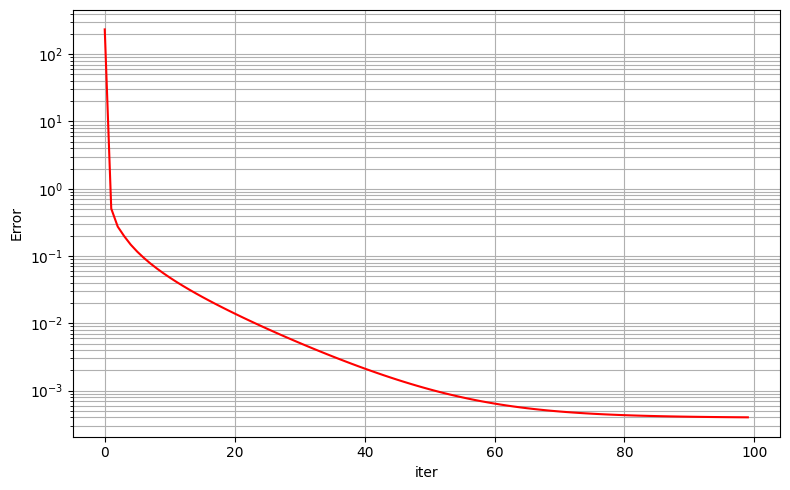

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 540x252 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5), dpi=100)
l=len(err)
x =list(range(0,l))
y =err
plt.semilogy(x, y, color="red")
# Display grid
plt.grid(True, which ="both")

# Provide the title for the semilogy plotplt.title('Y axis in Semilogy using Python Matplotlib')

# Give x axis label for the semilogy plot
plt.xlabel('iter')

# Give y axis label for the semilogy plot
plt.ylabel('Error')
plt.show()
plt.savefig('heart_err.eps', dpi=300)
files.download("heart_err.eps")

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,5,10])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    print(i)
    for j in range(len(c)):
        #r=random.randint(0, 150)
        print(i)
        y_pred,aa=test(c[i],a[j],100,à)
        print(aa)
        acc[i][j]=aa


0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.9
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8166666666666667
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.9
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8666666666666667
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8833333333333333
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8666666666666667
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8166666666666667
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.85
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8333333333333334
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8833333333333333
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8333333333333334
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8333333333333334
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8666666666666667
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8166666666666667
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8333333333333334
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.9166666666666666
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.85
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.7833333333333333
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8166666666666667
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8666666666666667
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8333333333333334
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8833333333333333
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.85
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.7833333333333333


In [ ]:
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.matrix([[0.9 , 0.81666667, 0.9 ,       0.86666667 ,0.88333333],
 [0.86666667 ,0.81666667, 0.85       ,0.83333333, 0.88333333],
 [0.83333333 ,0.83333333 ,0.86666667, 0.81666667 ,0.83333333],
 [0.91666667 ,0.8        ,0.85       ,0.78333333, 0.81666667],
 [0.86666667, 0.83333333, 0.88333333 ,0.85,       0.78333333]])
print(acc)

[[0.9        0.81666667 0.9        0.86666667 0.88333333]
 [0.86666667 0.81666667 0.85       0.83333333 0.88333333]
 [0.83333333 0.83333333 0.86666667 0.81666667 0.83333333]
 [0.91666667 0.8        0.85       0.78333333 0.81666667]
 [0.86666667 0.83333333 0.88333333 0.85       0.78333333]]


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = c,
    y = a,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


# **Prima**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['pima.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving pima.csv to pima.csv


In [ ]:
def test_pima(c,a,n,r=7):
    data = pd.read_csv("pima.csv")
    data.head()
    data = data.dropna()
    data.isnull().sum()
    #training and test datasets
    X=data[['num_preg', 'glucose_conc', 'diastolic_bp', 'insulin', 'bmi',
         'diab_pred', 'age', 'skin']]
    y=data['diabetes']
    # Splitting using scikit-learn train_test_split function
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    Y=[]
    for i in range(len(y)):
        if y[i]==y[0]:
            Y.append(1)
        else:
            Y.append(-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y,
                                              test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.1*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
#y_p,acc=test_pima(20,0.001,100,5)
y_p,acc=test_pima(20,0.001,100,5)
print(acc)





20 iteration ===> ACC=  0.737785016286645  and ERR= 0.016066844330042372
40 iteration ===> ACC=  0.737785016286645  and ERR= 0.002794174961762015
60 iteration ===> ACC=  0.737785016286645  and ERR= 0.0011813107035568953
80 iteration ===> ACC=  0.737785016286645  and ERR= 0.0009194287132494212
100 iteration ===> ACC=  0.739413680781759  and ERR= 0.0008396729344534633
              precision    recall  f1-score   support

          -1       0.89      0.74      0.81       100
           1       0.63      0.83      0.72        54

    accuracy                           0.77       154
   macro avg       0.76      0.79      0.76       154
weighted avg       0.80      0.77      0.78       154

0.7727272727272727


# **haberman**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['haberman.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving haberman.csv to haberman.csv


In [ ]:
def test_heb(c,a,n,r):
    data = pd.read_csv("haberman.csv")
    data.head()
    #data = data.dropna()
    #data.isnull().sum()
    #training and test datasets
    X = data[["Age","Op_Year","axil_nodes"]]
    y = data["Surv_status"]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 2:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)#10
    X_train=np.array(X_train);
    std = 0.1*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    #X_train= X_train+0.05*(2*np.random.random(X_train.shape)-1);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,err,cost=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc,err

In [ ]:
y_pred,aa,err=test_heb(1e1,-1,100,7)

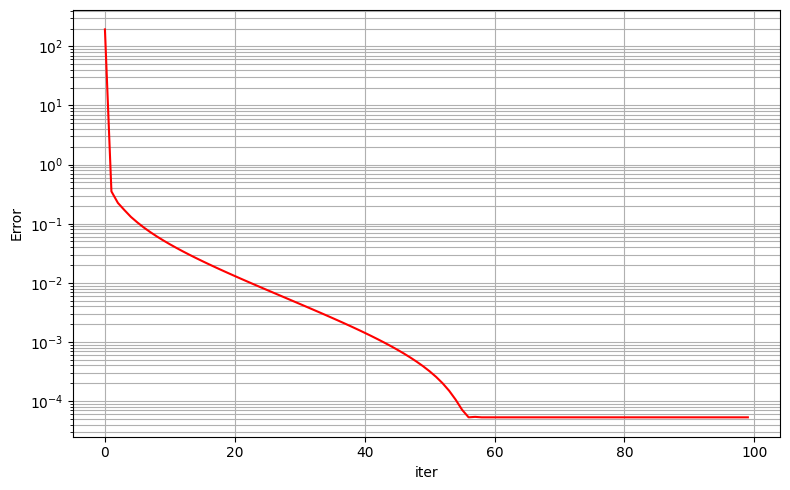

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 540x252 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5), dpi=100)
l=len(err)
x =list(range(0,l))
y =err
plt.semilogy(x, y, color="red")
# Display grid
plt.grid(True, which ="both")

# Provide the title for the semilogy plotplt.title('Y axis in Semilogy using Python Matplotlib')

# Give x axis label for the semilogy plot
plt.xlabel('iter')

# Give y axis label for the semilogy plot
plt.ylabel('Error')
plt.show()
plt.savefig('heber_err.eps', dpi=300)
files.download("heber_err.eps")

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,5,10])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    for j in range(len(c)):
        r=random.randint(0, 150)
        print(i)
        y_pred,aa=test_heb(1e1,-1,100,r)
        print(aa)
        acc[i][j]=aa




0
0.6935483870967742
0
0.6935483870967742
0
0.7580645161290323
0
0.7258064516129032
0
0.6129032258064516
1
0.7258064516129032
1
0.7258064516129032
1
0.7419354838709677
1
0.8064516129032258
1
0.6290322580645161
2
0.6935483870967742
2
0.6451612903225806
2
0.6935483870967742
2
0.7580645161290323
2
0.7580645161290323
3
0.7258064516129032
3
0.6451612903225806
3
0.7096774193548387
3
0.6451612903225806
3
0.6774193548387096
4
0.7741935483870968
4
0.6290322580645161
4
0.6774193548387096
4
0.6774193548387096
4
0.7580645161290323


In [ ]:
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,5,10])
acc=np.matrix([[0.69354839, 0.69354839, 0.75806452, 0.72580645, 0.61290323],
 [0.72580645, 0.72580645, 0.74193548, 0.80645161, 0.62903226],
 [0.69354839, 0.64516129, 0.69354839, 0.75806452, 0.75806452],
 [0.72580645, 0.64516129, 0.70967742, 0.64516129, 0.67741935],
 [0.77419355, 0.62903226, 0.67741935, 0.67741935, 0.75806452]])
print(acc)

[[0.69354839 0.69354839 0.75806452 0.72580645 0.61290323]
 [0.72580645 0.72580645 0.74193548 0.80645161 0.62903226]
 [0.69354839 0.64516129 0.69354839 0.75806452 0.75806452]
 [0.72580645 0.64516129 0.70967742 0.64516129 0.67741935]
 [0.77419355 0.62903226 0.67741935 0.67741935 0.75806452]]


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = c,
    y = a,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


## **Exemple Ionosphere**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Ionosphere.csv']))
# Dataset is now stored in a Pandas Dataframe

Saving Ionosphere.csv to Ionosphere.csv


In [ ]:
data = pd.read_csv("Ionosphere.csv")
data.head()
data.shape

In [ ]:
def test_Ionosphere(kernel_param,epoch,kernel_type=3):
    data = pd.read_csv("Ionosphere.csv")
    data.head()
    #data = data.dropna()
    #data.isnull().sum()
    #training and test datasets
    X = data[["V1","V2","V3","V4","V5","V6",
              "V7","V8","V9","V10","V11",
              "V12","V13","V14","V15","V16",
              "V17","V18","V19","V20","V21",
              "V22","V23","V24","V25","V26",
              "V27","V28","V29","V30","V31",
              "V32","V33","V34"]]
    y = data["Class"]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 0:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)
    X_train=np.array(X_train);
    X_train= X_train+0.05*(2*np.random.random(X_train.shape)-1);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    C1=1e-0
    C2=1e-0
    acc,y_pred,err_r=KernelTWSVM( X_train, Y_train, X_test, Y_test, C1, C2, kernel_type,kernel_param,epoch)
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_pred))
    return acc,y_pred,err_r

In [ ]:
acc,y_pred,err_r=test_Ionosphere(4.5,200)
print(acc)

%%%%%%%%%%%% Twin SVM 1 %%%%%%%%%%%%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


TSVM1 ===> Epoch=  40
TSVM1 ===> Epoch=  80
TSVM1 ===> Epoch=  120
TSVM1 ===> Epoch=  160
TSVM1 ===> Epoch=  200
%%%%%%%%%%%% Twin SVM 2 %%%%%%%%%%%%
TSVM1 ===> Epoch=  40
TSVM1 ===> Epoch=  80
TSVM1 ===> Epoch=  120
TSVM1 ===> Epoch=  160
TSVM1 ===> Epoch=  200
              precision    recall  f1-score   support

          -1       0.92      0.96      0.94        23
           1       0.98      0.96      0.97        48

    accuracy                           0.96        71
   macro avg       0.95      0.96      0.95        71
weighted avg       0.96      0.96      0.96        71

0.9577464788732394


# **liver_disorder**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['liver_disorder.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving liver_disorder.csv to liver_disorder.csv


In [ ]:
def test_l(c,a,n,r=7):
    data = pd.read_csv("liver_disorder.csv")
    data.head()
    #data = data.dropna()
    #data.isnull().sum()
    #training and test datasets
    X = data[["mcv","alkphos","sgpt","sgot","gammagt","drinks"]]
    y = data["selector"]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 0:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.05*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    #X_train= X_train+0.1*(2*np.random.random(X_train.shape)-1);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,err,cost=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    #print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc,err

In [ ]:
y_pred,aa,err=test_l(1,1,100,7)

In [ ]:
print(err[80:90])

[2.050517017691066e-05, 1.7941048755990632e-05, 1.5964793277384287e-05, 1.4582598884537089e-05, 1.3773796691618604e-05, 1.3477116227406783e-05, 1.3477116227406783e-05, 1.3477116227406783e-05, 1.3477116227406783e-05, 1.3477116227406783e-05]


In [ ]:
for i in list(range(86,100)):
    err[i]=1.3477116227406783e-05

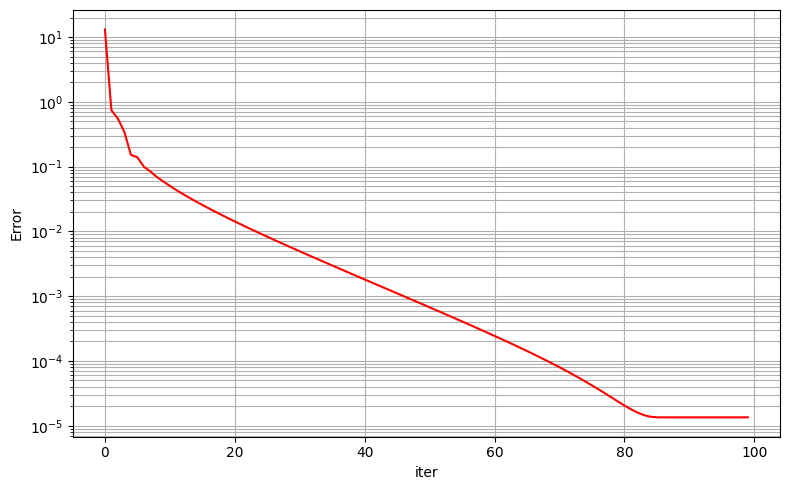

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 540x252 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5), dpi=100)
l=len(err)
x =list(range(0,l))
y =err
plt.semilogy(x, y, color="red")
# Display grid
plt.grid(True, which ="both")

# Provide the title for the semilogy plotplt.title('Y axis in Semilogy using Python Matplotlib')

# Give x axis label for the semilogy plot
plt.xlabel('iter')

# Give y axis label for the semilogy plot
plt.ylabel('Error')
plt.show()
plt.savefig('liver_disorder_err.eps', dpi=300)
files.download("liver_disorder_err.eps")

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    for j in range(len(c)):
        r=random.randint(0, 150)
        print(i)
        y_pred,aa=test_l(1,1,100,r)
        print(aa)
        acc[i][j]=aa





0


KeyboardInterrupt: ignored

In [ ]:
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.matrix([[0.56521739, 0.66666667, 0.62318841, 0.5942029,  0.57971014],
 [0.69565217, 0.68115942, 0.60869565, 0.66666667, 0.53623188],
 [0.60869565, 0.62318841, 0.68115942, 0.68115942, 0.62318841],
 [0.60869565, 0.5942029,  0.56521739, 0.68115942, 0.5942029 ],
 [0.65217391, 0.5942029,  0.75363768, 0.52173913, 0.57971014]])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = a,
    y = c,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# **Ionosphere**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Ionosphere.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving Ionosphere.csv to Ionosphere.csv


In [ ]:
def test_I(c,a,n,r=7):
    data = pd.read_csv("Ionosphere.csv")
    data.head()
    #data = data.dropna()
    #data.isnull().sum()
    #training and test datasets
    X = data[["V1","V2","V3","V4","V5","V6",
              "V7","V8","V9","V10","V11",
              "V12","V13","V14","V15","V16",
              "V17","V18","V19","V20","V21",
              "V22","V23","V24","V25","V26",
              "V27","V28","V29","V30","V31",
              "V32","V33","V34"]]
    y = data["Class"]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 0:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    """std = 0.1*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;"""
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    #print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    for j in range(len(c)):
        r=random.randint(0, 150)
        print(i)
        y_pred,aa=test_I(0.01,0.1,100,r)
        print(aa)
        acc[i][j]=aa






0
0.8591549295774648
0
0.9295774647887324
0
0.8873239436619719
0
0.8873239436619719
0
0.9295774647887324
1
0.8732394366197183
1
0.8450704225352113
1
0.8873239436619719
1
0.9014084507042254
1
0.8732394366197183
2
0.8732394366197183
2
0.9014084507042254
2
0.8309859154929577
2
0.9154929577464789
2
0.8309859154929577
3
0.9014084507042254
3
0.8732394366197183
3
0.9014084507042254
3
0.8732394366197183
3
0.9295774647887324
4
0.8873239436619719
4
0.8873239436619719
4
0.8591549295774648
4
0.9154929577464789
4
0.8450704225352113


In [ ]:
acc=np.matrix([[0.85915493, 0.92957746, 0.88732394, 0.88732394, 0.92957746],
 [0.87323944, 0.84507042, 0.88732394, 0.90140845, 0.87323944],
 [0.87323944, 0.90140845, 0.83098592, 0.91549296, 0.83098592],
 [0.90140845, 0.87323944, 0.90140845, 0.87323944, 0.92957746],
 [0.88732394, 0.88732394, 0.85915493, 0.91549296, 0.84507042]])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = a,
    y = c,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# **australian**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['australian.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving australian.csv to australian.csv


In [ ]:
def test_au(c,a,n,r=7):
    data = pd.read_csv("australian.csv")
    data.head()
    X = data[["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","A11","A12","A13","A14"]]
    y = data['Class']
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 0:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.5*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    #print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,5,10])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    for j in range(len(c)):
        r=random.randint(0, 150)
        print(i)
        y_pred,aa=test_au(1,1,100,r)
        print(aa)
        acc[i][j]=aa



0
0.8405797101449275
0
0.8623188405797102
0
0.8333333333333334
0
0.8913043478260869
0
0.8840579710144928
1
0.8840579710144928
1
0.8913043478260869
1
0.8623188405797102
1
0.8840579710144928
1
0.8623188405797102
2
0.9130434782608695
2
0.8695652173913043
2
0.8333333333333334
2
0.8333333333333334
2
0.8405797101449275
3
0.8695652173913043
3
0.8985507246376812
3
0.8695652173913043
3
0.8695652173913043
3
0.8695652173913043
4
0.8695652173913043
4
0.8768115942028986
4
0.8985507246376812
4
0.8333333333333334
4
0.8188405797101449


In [ ]:
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.matrix([[0.84057971, 0.86231884, 0.83333333, 0.89130435, 0.88405797],
 [0.88405797 ,0.89130435, 0.86231884 ,0.88405797, 0.86231884],
 [0.91304348 ,0.86956522, 0.83333333, 0.83333333, 0.84057971],
 [0.86956522, 0.89855072, 0.86956522, 0.86956522, 0.86956522],
 [0.86956522, 0.87681159, 0.89855072, 0.83333333, 0.81884058]])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = a,
    y = c,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# **diabetes**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['diabetes-dataset.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving diabetes-dataset.csv to diabetes-dataset.csv


In [ ]:
def test_d(c,a,n,r=7):
    data = pd.read_csv("diabetes-dataset.csv")
    data.head()
    X = data[["Pregnancies",	"Glucose",	"BloodPressure",	"SkinThickness",	"Insulin",	"BMI",	"DiabetesPedigreeFunction",	"Age"]]
    X=X[0:768]
    y = data['Outcome']
    y=y[0:768]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 0:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    #X_train= X_train+0.05*(2*np.random.random(X_train.shape)-1);
    std = 0.1*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
y_p,acc=test_d(2.1,0.5,100,5)
print(acc)





20 iteration ===> ACC=  0.7263843648208469  and ERR= 0.016436252039744675
40 iteration ===> ACC=  0.7263843648208469  and ERR= 0.00233719568336462
60 iteration ===> ACC=  0.7263843648208469  and ERR= 0.000564625297742441
80 iteration ===> ACC=  0.7247557003257329  and ERR= 0.00030835980357055446
100 iteration ===> ACC=  0.7247557003257329  and ERR= 0.0002676409179515769
              precision    recall  f1-score   support

          -1       0.89      0.74      0.81        98
           1       0.65      0.84      0.73        56

    accuracy                           0.78       154
   macro avg       0.77      0.79      0.77       154
weighted avg       0.80      0.78      0.78       154

0.7792207792207793


# **sonar**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['sonar.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving sonar.csv to sonar.csv


In [ ]:
def test_s(c,a,n,r=7):
    data = pd.read_csv("sonar.csv",names=range(0, 61),header=None)
    data.head()
    names = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
    data.columns = names
    data['Class']=np.where(data[60]==data[60][1],1,-1)
    X = data[[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59]]
    y = data['Class']
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    y=np.array(y);
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.1*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    #print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
import random
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,5,10])
acc=np.zeros((len(a),len(c)))
acc=np.array(acc)
for i in range(len(a)):
    for j in range(len(c)):
        r=random.randint(0, 150)
        print(i)
        y_pred,aa=test_s(1,1,100,r)
        print(aa)
        acc[i][j]=aa




0
0.7619047619047619
0
0.6904761904761905
0
0.8571428571428571
0
0.7619047619047619
0
0.7142857142857143
1
0.7380952380952381
1
0.6904761904761905
1
0.6190476190476191
1
0.6428571428571429
1
0.8095238095238095
2
0.6428571428571429
2
0.7619047619047619
2
0.7619047619047619
2
0.6904761904761905
2
0.7857142857142857
3
0.6904761904761905
3
0.7142857142857143
3
0.7380952380952381
3
0.7142857142857143
3
0.8333333333333334
4
0.7380952380952381
4
0.6904761904761905
4
0.7380952380952381
4
0.6190476190476191
4
0.7619047619047619


In [ ]:
a=np.array([0.05,0.1,0.5,1,5])
c=np.array([0.01,0.1,1,10,100])
acc=np.matrix([[0.76190476, 0.69047619, 0.85714286, 0.76190476, 0.71428571],
 [0.73809524, 0.69047619, 0.61904762, 0.64285714, 0.80952381],
 [0.64285714, 0.76190476, 0.76190476, 0.69047619, 0.78571429],
 [0.69047619, 0.71428571, 0.73809524, 0.71428571, 0.83333333],
 [0.73809524, 0.69047619, 0.73809524, 0.61904762, 0.76190476]])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Surface(contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },

    x = a,
    y = c,
    z = acc,colorscale='rdylgn'))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='a',
                    yaxis_title='c',
                    zaxis_title='Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# **wpbc**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['wpbc.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving wpbc.csv to wpbc.csv


In [ ]:
data = pd.read_csv("wpbc.csv")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [ ]:
def test_w(c,a,n,r=7):
    data = pd.read_csv("wpbc.csv")
    data.drop(['id'], axis = 1, inplace = True)
    data.drop(['Unnamed: 32'], axis = 1, inplace = True)
    data['diagnosis'] = data['diagnosis'].map({'M': -1, 'B': 1})
    data.head()
    #data = data.dropna()
    #data.isnull().sum()
    #training and test datasets
    X = data[["radius_mean","texture_mean",
              "perimeter_mean","area_mean","smoothness_mean",
              "compactness_mean","concavity_mean",
              "concave points_mean","symmetry_mean",
              "fractal_dimension_mean","radius_se","texture_se",
              "perimeter_se","area_se","smoothness_se","compactness_se",
              "concavity_se","concave points_se","symmetry_se","fractal_dimension_se",
              "radius_worst","texture_worst","perimeter_worst",
              "area_worst","smoothness_worst","compactness_worst",
              "concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]]
    y = data["diagnosis"]
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 'B':
            y[i]=-1
        if y[i] == 'M':
            y[i]=1
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.05*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train+noise;
    #X_train= X_train+0.05*(2*np.random.random(X_train.shape)-1);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
y_p,acc=test_w(1,1,100,99)
print(acc)





20 iteration ===> ACC=  0.9428571428571428  and ERR= 0.019037172350425662
40 iteration ===> ACC=  0.9428571428571428  and ERR= 0.002399035152867708
60 iteration ===> ACC=  0.9428571428571428  and ERR= 0.0003484462068036018
80 iteration ===> ACC=  0.9428571428571428  and ERR= 5.1591308119802934e-05
100 iteration ===> ACC=  0.9428571428571428  and ERR= 7.663615123543935e-06
              precision    recall  f1-score   support

          -1       0.89      0.84      0.86        38
           1       0.92      0.95      0.94        76

    accuracy                           0.91       114
   macro avg       0.91      0.89      0.90       114
weighted avg       0.91      0.91      0.91       114

0.9122807017543859


# **vote**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['house-votes-84-data.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving house-votes-84-data.csv to house-votes-84-data.csv


In [ ]:
def test_v(c,a,n,r=7):
    df= pd.read_csv('house-votes-84-data.csv')
    def replace(column_name):
        mode = df[column_name].mode(dropna=True)[0]
        df[column_name] = df[column_name].replace('?', mode)
        df[column_name] = df[column_name].replace('y', 1)
        df[column_name] = df[column_name].replace('n', 0)
        df[column_name] = df[column_name].replace('republican', 1)
        df[column_name] = df[column_name].replace('democrat', -1)
    f = df.columns
    for column_name in f:
        replace(column_name)

    y = df['party']
    X = df.drop('party', axis = 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    X_train=np.array(X_train);
    std = 0.05*np.std(X_train)
    noise = np.random.normal(0, std, X_train.shape)
    X_train= X_train*(1+noise);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    return y_p,acc

In [ ]:
#y_p,acc=test_g(5,2,100,6)(1,1,100,4)
y_p,acc=test_v(2,0.1,100,21)
print(acc)




20 iteration ===> ACC=  0.9051724137931034  and ERR= 0.04634910790967804
40 iteration ===> ACC=  0.9022988505747126  and ERR= 0.0021326840174654416
60 iteration ===> ACC=  0.9022988505747126  and ERR= 0.0006676676606276247
80 iteration ===> ACC=  0.9022988505747126  and ERR= 0.0005720974633999173
100 iteration ===> ACC=  0.9022988505747126  and ERR= 0.0005544989027630303
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        51
           1       1.00      0.94      0.97        36

    accuracy                           0.98        87
   macro avg       0.98      0.97      0.98        87
weighted avg       0.98      0.98      0.98        87

0.9770114942528736


# **HandPD**

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
#df2 = pd.read_csv(io.BytesIO(uploaded['NewSpiral.csv']))
df2 = pd.read_csv(io.BytesIO(uploaded['NewMeander.csv']))
# Dataset is now stored in a Pandas Dataframe


Saving NewMeander.csv to NewMeander.csv


In [ ]:
def test_v(c,a,n,r=7):
    df= pd.read_csv('NewSpiral.csv')
    #df= pd.read_csv('NewMeander.csv')
    def replace(column_name):
        mode = df[column_name].mode(dropna=True)[0]
        df[column_name] = df[column_name].replace('M', 1)
        df[column_name] = df[column_name].replace('F', 0)
        df[column_name] = df[column_name].replace('R', 1)
        df[column_name] = df[column_name].replace('L', 0)
    f = df.columns
    for column_name in f:
        replace(column_name)
    X = df[["GENDER","RIGH/LEFT-HANDED","AGE","RMS","MAX_BETWEEN_ET_HT","MIN_BETWEEN_ET_HT",
              "STD_DEVIATION_ET_HT","MRT","MAX_HT","MIN_HT","STD_HT","CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT"]]
    y = df["CLASS_TYPE"]
    y=np.array(y)
    y=np.array(y)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(data=X_scaled, index=X.index, columns= X.columns)
    for i in range(len(y)):
        if y[i] == 2:
            y[i]=-1
    X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, y, test_size=0.25, random_state=r)
    X_train=np.array(X_train);
    Y_train=np.array(Y_train);
    X_test=np.array(X_test);
    Y_test=np.array(Y_test);
    Xmin,X2,cost=train_model(X_train,Y_train,c,a,n)
    y_p=np.sign(model(X_test.T,Xmin,1));
    #Y_test=Y_test.reshape((len(Y_test),1))
    from sklearn import metrics
    print(metrics.classification_report(Y_test, y_p.T))
    acc=accuracy_score(y_p.T,Y_test)
    print(precision_recall_fscore_support(y_p.T,Y_test, average='macro'))
    print(precision_recall_fscore_support(y_p.T,Y_test, average='micro'))
    print(precision_recall_fscore_support(y_p.T,Y_test, average='weighted'))
    """from sklearn.metrics import confusion_matrix
    cmat = confusion_matrix(y_p.T,Y_test)
    cmat.diagonal()/cmat.sum(axis=1)
    print(cmat.diagonal()/cmat.sum(axis=1))"""
    return y_p,acc

In [ ]:
#y_p,acc=test_v(0.2,1,100,6) #50% TRAI SPIRAL
y_p,acc=test_v(0.1,1,100,6) #75% TRAI SPIRAL
#y_p,acc=test_v(0.3,1,100,71) #50% TRAI
#y_p,acc=test_v(0.1,1,100,10) #75% TRAI
print(acc)




              precision    recall  f1-score   support

          -1       0.89      0.94      0.92        35
           1       0.93      0.87      0.90        31

    accuracy                           0.91        66
   macro avg       0.91      0.91      0.91        66
weighted avg       0.91      0.91      0.91        66

(0.9069124423963133, 0.9114631873252563, 0.9083333333333334, None)
(0.9090909090909091, 0.9090909090909091, 0.9090909090909091, None)
(0.9112693757855048, 0.9090909090909091, 0.9093434343434345, None)
0.9090909090909091


In [ ]:
from sklearn.metrics import precision_recall_fscore_support



array([1.        , 0.        , 0.66666667])